# SLEEP POSTURE MONITORING



In [1]:
# Libraries
import sys
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sas
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from numpy import linalg as la
from sklearn.cluster import KMeans
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

**PREPROCESSING FUNCTIONS**

In [2]:
def PCA(file):
    df = pd.read_csv(file, sep="\t", header=None)
    df.drop(columns=[2048], inplace = True) 
    df.drop(0, inplace = True) 
    df.drop(1, inplace = True)
    df.drop(2, inplace = True)
    
    array = df.to_numpy()
    avg = np.mean(array, axis = 1, keepdims=True)

    array = array - avg

    CX = np.cov(array)
    w,v = la.eig(CX) 

    CY =  np.diag(np.round(np.real(w),2))
    
    tr = 0;
    for i in range(0,5):
        tr = tr + CY[i,i]
        print("Fraction of the total variability keeping", i,"the first principal component: ", np.round(100*tr/CY.trace()),"%")

    P = v[:,0:1]
    P = abs(P)

    array_final = P.T.dot(array)
        
    return array_final

def rescale(pressure_map, max_value, min_value):  
    maximum = pressure_map.max()
    minimum = pressure_map.min()  
    OldRange = maximum - minimum
    NewRange = max_value - min_value

    for i in range(0,len(pressure_map)):
        pressure_map[i] = (((pressure_map[i] - minimum) * NewRange) / OldRange) 
            
    return pressure_map

def kMeans(section):
    X = []
    
    for i in range(0, section.shape[0]):
        for j in range(0, section.shape[1]):
            t = []
            t.append(i)
            t.append(j)
            t.append(section[i][j])
            X.append(t)

    X = np.array(X)

    kmeans = KMeans(n_clusters=2).fit(X)
    
    # compute x, y centroid and avg intensity in cluster
    cluster_1 = []
    cluster_2 = []

    for i in range(0,len(X)):
        if kmeans.labels_[i] == 0:
            cluster_1.append(X[i])
        else:
            cluster_2.append(X[i])

    mean_1 = np.mean(cluster_1, axis = 0) 
    mean_2 = np.mean(cluster_2, axis = 0) 

    if mean_1[2] > mean_2[2]:
        mean_cluster = mean_1[2]
        y_pos = kmeans.cluster_centers_[0][0]
        x_pos = kmeans.cluster_centers_[0][1]
    else:
        mean_cluster = mean_2[2]
        y_pos = kmeans.cluster_centers_[1][0]
        x_pos = kmeans.cluster_centers_[1][1]

    
    return x_pos, y_pos, mean_cluster, kmeans.labels_


**IMPORTING AND PLOTTING DATA**

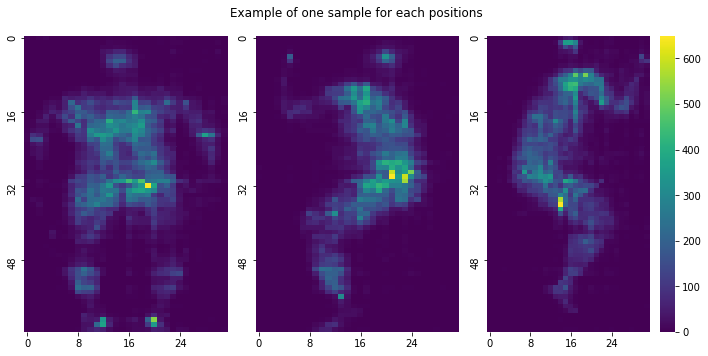

In [3]:
#collecting some examples of data from the first part of the dataset
data_folder = Path("dataset/experiment-i/S3/")

file_name = []
array = []

file_name.append(data_folder / "1.txt")
file_name.append(data_folder / "2.txt")
file_name.append(data_folder / "3.txt")

for i in range(0,len(file_name)):
    df = pd.read_csv(file_name[i], sep="\t", header=None)
    df.drop(columns=[2048], inplace = True) 
    df.drop(0, inplace = True) 
    df.drop(1, inplace = True) 
    df.drop(2, inplace = True) 
    
    array.append(df.to_numpy())


#plotting one sample for each imported file 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Example of one sample for each positions')
g1 = sas.heatmap(np.flip(array[0][1].reshape(64,32),1), cmap="viridis", cbar=False, ax=ax1, xticklabels=8, yticklabels=16)
g2 = sas.heatmap(np.flip(array[1][1].reshape(64,32),1), cmap="viridis", cbar=False, ax=ax2, xticklabels=8, yticklabels=16)
g3 = sas.heatmap(np.flip(array[2][1].reshape(64,32),1), cmap="viridis", ax=ax3, xticklabels=8, yticklabels=16)
plt.tight_layout()
plt.show()


**PCA RESULTS**

In [4]:
PCA_result = []
for i in range(0, len(file_name)):
    print("POSITION", i, "\n")
    tmp = PCA(file_name[i])
    PCA_result.append(rescale(tmp, 1000, 0))
    print("\n")
    

POSITION 0 

Fraction of the total variability keeping 0 the first principal component:  100.0 %
Fraction of the total variability keeping 1 the first principal component:  100.0 %
Fraction of the total variability keeping 2 the first principal component:  100.0 %
Fraction of the total variability keeping 3 the first principal component:  100.0 %
Fraction of the total variability keeping 4 the first principal component:  100.0 %


POSITION 1 

Fraction of the total variability keeping 0 the first principal component:  100.0 %
Fraction of the total variability keeping 1 the first principal component:  100.0 %
Fraction of the total variability keeping 2 the first principal component:  100.0 %
Fraction of the total variability keeping 3 the first principal component:  100.0 %
Fraction of the total variability keeping 4 the first principal component:  100.0 %


POSITION 2 

Fraction of the total variability keeping 0 the first principal component:  100.0 %
Fraction of the total variability

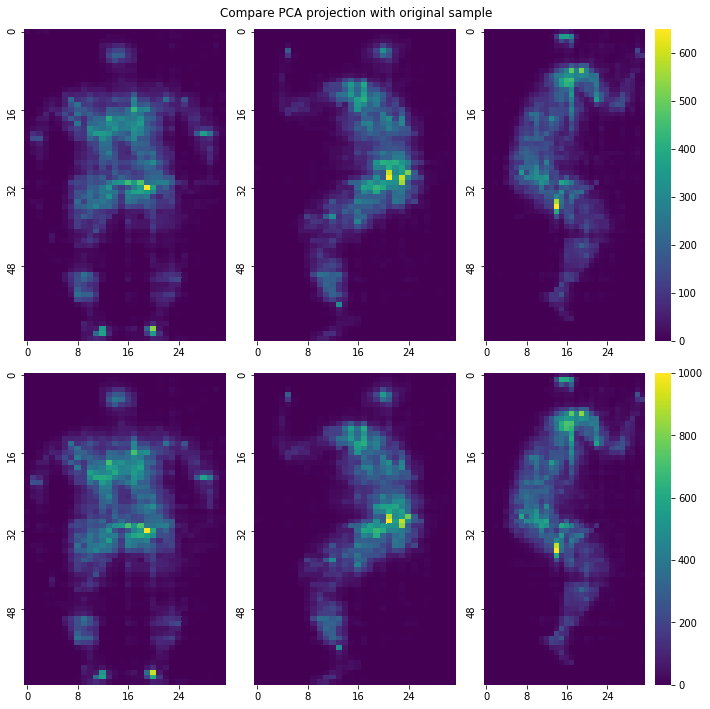

In [5]:
#plot the results of the PCA 
fig, ax = plt.subplots(2, 3, figsize=(10,10))
fig.suptitle('Compare PCA projection with original sample')
g1 = sas.heatmap(np.flip(array[0][1].reshape(64,32),1),cmap="viridis",cbar=False,ax=ax[0,0], xticklabels=8, yticklabels=16)
g2 = sas.heatmap(np.flip(array[1][1].reshape(64,32),1),cmap="viridis",cbar=False,ax=ax[0,1], xticklabels=8, yticklabels=16)
g3 = sas.heatmap(np.flip(array[2][1].reshape(64,32),1),cmap="viridis",ax=ax[0,2], xticklabels=8, yticklabels=16)
g4 = sas.heatmap(np.flip(PCA_result[0].reshape(64,32),1),cmap="viridis",cbar=False,ax=ax[1,0], xticklabels=8, yticklabels=16)
g5 = sas.heatmap(np.flip(PCA_result[1].reshape(64,32),1),cmap="viridis",cbar=False,ax=ax[1,1], xticklabels=8, yticklabels=16)
g6 = sas.heatmap(np.flip(PCA_result[2].reshape(64,32),1),cmap="viridis",ax=ax[1,2], xticklabels=8, yticklabels=16)
plt.tight_layout()
plt.show()


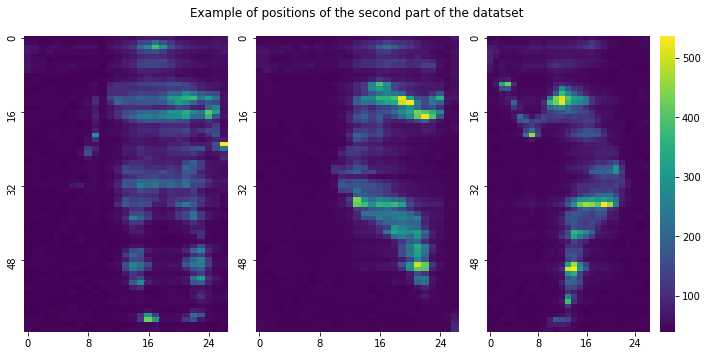

In [6]:
#collecting some examples of data from the second part of the dataset
data_folder = Path("dataset/experiment-ii/S3/Air_Mat/")

file_name = []
array_2 = []

file_name.append(data_folder / "Matrix_Air_B3.txt")
file_name.append(data_folder / "Matrix_Air_D1.txt")
file_name.append(data_folder / "Matrix_Air_C2.txt")

for i in range(0,len(file_name)):
    df = pd.read_csv(file_name[i], sep=" ", header=None)
    
    array_2.append(df.to_numpy())

#plotting one sample for each imported file
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Example of positions of the second part of the datatset')
g1 = sas.heatmap(np.flip(array_2[0].reshape(64,27),0),cmap="viridis",cbar=False,ax=ax1, xticklabels=8, yticklabels=16)
g2 = sas.heatmap(np.flip(array_2[1].reshape(64,27),0),cmap="viridis",cbar=False,ax=ax2, xticklabels=8, yticklabels=16)
g3 = sas.heatmap(np.flip(array_2[2].reshape(64,27),0),cmap="viridis",ax=ax3, xticklabels=8, yticklabels=16)
plt.tight_layout()
plt.show()


**K-MEANS RESULTS**

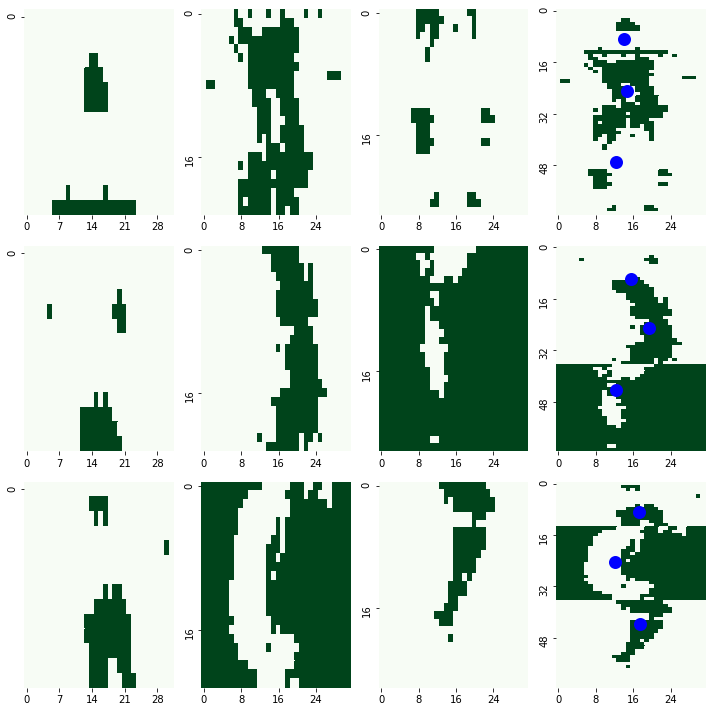

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(10,10))

for i in range(0,len(PCA_result)):
    tmp = np.flip(PCA_result[i].reshape(64,32),1)
    section1 = tmp[:14]
    section2 = tmp[14:37]
    section3 = tmp[37:]
    pos_h_x, pos_h_y, mean_h, labels_1 = kMeans(section1)
    pos_c_x, pos_c_y, mean_c, labels_2 = kMeans(section2)
    pos_l_x, pos_l_y, mean_l, labels_3 = kMeans(section3)
    
    tot = np.concatenate((labels_1, labels_2, labels_3), axis=0)
    
    g1 = sas.heatmap(labels_1.reshape(14,32),cmap="Greens",cbar=False,ax=ax[i,0], xticklabels=7, yticklabels=16)
    #ax[i,0].scatter(pos_h_x, pos_h_y, marker='o', s=100, linewidths=3, color='g', zorder=10)
    g2 = sas.heatmap(labels_2.reshape(23,32),cmap="Greens",cbar=False,ax=ax[i,1], xticklabels=8, yticklabels=16)
    #ax[i,1].scatter(pos_c_x, pos_c_y, marker='o', s=100, linewidths=3, color='g', zorder=10)
    g3 = sas.heatmap(labels_3.reshape(27,32),cmap="Greens",cbar=False,ax=ax[i,2], xticklabels=8, yticklabels=16)
    #ax[i,2].scatter(pos_l_x, pos_l_y, marker='o', s=100, linewidths=3, color='g', zorder=10)
    g4 = sas.heatmap(tot.reshape(64,32),cmap="Greens",cbar=False,ax=ax[i,3], xticklabels=8, yticklabels=16)
    ax[i,3].scatter(pos_h_x, pos_h_y, marker='o', s=100, linewidths=3, color='b', zorder=10)
    ax[i,3].scatter(pos_c_x, pos_c_y + 14, marker='o', s=100, linewidths=3, color='b', zorder=10)
    ax[i,3].scatter(pos_l_x, pos_l_y + 37, marker='o', s=100, linewidths=3, color='b', zorder=10)
    
plt.tight_layout()
plt.show()


**DATASETS**

In [8]:
dataset_exp1 = pd.read_csv('dataset.csv')
dataset_exp1 = dataset_exp1.sample(frac=1).reset_index(drop=True)
dataset_exp1

1 x 1  1 x 2  1 x 3  1 x 4     1 x 5     1 x 6     1 x 7     1 x 8  \
0     0.000000    0.0    0.0    0.0  0.000000  0.000000  0.000000  0.000000   
1     0.000000    0.0    0.0    0.0  0.000000  0.000000  0.000000  0.000000   
2     0.000000    0.0    0.0    0.0  0.000000  0.000000  0.000000  0.013633   
3     0.000000    0.0    0.0    0.0  0.000000  0.000000  0.150288  0.000000   
4     0.000000    0.0    0.0    0.0  0.000000  0.000000  0.000000  0.000000   
...        ...    ...    ...    ...       ...       ...       ...       ...   
2667  0.000000    0.0    0.0    0.0  0.000000  0.000000  0.000000  0.000000   
2668  0.059513    0.0    0.0    0.0  0.000000  0.569471  0.000000  0.000000   
2669  0.000000    0.0    0.0    0.0  0.000000  0.000000  0.000000  0.000000   
2670  0.000000    0.0    0.0    0.0  0.473501  0.035150  0.031691  0.003879   
2671  0.000000    0.0    0.0    0.0  0.000000  0.000000  0.010136  0.026726   

         1 x 9    1 x 10  ...    64 x 25   64 x 26   64 x 27   64 x 28  \
0     0.000000  0.000000  ...   6.433933  1.714537  0.809545  0.113832   
1     0.000000  0.000000  ...  27.398743  7.297952  2.023463  0.296902   
2     2.309617  0.102778  ...   6.000025  0.563663  0.000000  1.308589   
3     1.440236  0.198408  ...   8.598307  5.464370  1.072547  2.990647   
4     0.599161  0.000000  ...   3.188741  5.991216  0.978857  5.654437   
...        ...       ...  ...        ...       ...       ...       ...   
2667  1.550011  0.000000  ...   8.347939  1.282959  0.633206  1.063551   
2668  0.000000  0.000000  ...   0.575177  1.156771  0.048629  0.339696   
2669  0.000000  0.000000  ...   0.805236  0.136378  0.000000  0.152994   
2670  0.018002  0.029826  ...   1.804116  0.109954  0.003237  0.021659   
2671  0.962884  0.008038  ...   6.960647  1.879635  0.175419  0.467778   

       64 x 29   64 x 30   64 x 31   64 x 32  Subject  Position  
0     0.924806  0.213408  0.000000  0.457263        7         2  
1     0.644035  0.039362  0.000000  0.417008        5         2  
2     0.000000  0.089803  0.000000  0.017107        1         1  
3     2.067308  0.043761  0.000000  0.362624        1         0  
4     1.767684  0.037060  0.000000  1.721945        7         0  
...        ...       ...       ...       ...      ...       ...  
2667  0.046162  0.000000  0.000000  0.000000        9         1  
2668  2.690977  0.618703  0.677784  0.106525        2         1  
2669  0.458128  1.280420  0.000000  0.583743        9         1  
2670  1.299750  0.210236  0.000000  0.479080       11         1  
2671  0.478828  0.000000  0.139576  0.146495        0         2  

[2672 rows x 2050 columns]

In [9]:
dataset_exp2 = pd.read_csv('dataset_2.csv', sep=",", header=0)
dataset_exp2 = dataset_exp1.sample(frac=1).reset_index(drop=True)
dataset_exp2

1 x 1     1 x 2     1 x 3      1 x 4     1 x 5     1 x 6     1 x 7  \
0     0.000000  0.006204  0.000000   0.283755  0.000000  0.000000  0.596797   
1     0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.005401   
2     0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
3     0.000000  0.858771  0.253491  32.435258  4.530840  0.357771  0.244400   
4     0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...        ...       ...       ...       ...   
2667  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
2668  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
2669  0.000000  0.000000  0.000000   0.036943  0.000000  0.020297  1.255334   
2670  0.084576  0.027471  0.125713   0.120816  0.109542  0.047506  0.068710   
2671  0.000000  0.035400  0.000000   0.017828  0.000000  0.196604  0.000000   

         1 x 8     1 x 9    1 x 10  ...   64 x 25   64 x 26   64 x 27  \
0     1.121937  1.919260  3.146918  ...  9.254096  3.103593  0.513169   
1     0.005944  0.001016  0.000000  ...  1.903431  0.047835  0.319431   
2     0.000000  0.000000  0.000000  ...  6.433933  1.714537  0.809545   
3     0.000000  0.000000  0.000000  ...  2.311738  1.543943  0.000000   
4     0.000000  0.044188  0.000000  ...  1.893347  1.325530  0.172233   
...        ...       ...       ...  ...       ...       ...       ...   
2667  0.000000  0.139518  0.000000  ...  3.126370  1.623389  0.666440   
2668  0.000000  0.000000  0.000000  ...  2.022912  0.365861  0.093239   
2669  0.000000  0.000000  0.000000  ...  4.942999  3.129061  1.257913   
2670  0.328762  0.344226  0.381768  ...  1.710656  0.426191  0.121500   
2671  0.000000  0.000000  0.000000  ...  0.759783  0.089360  0.000000   

       64 x 28   64 x 29   64 x 30   64 x 31   64 x 32  Subject  Position  
0     0.429560  1.905993  0.180440  0.160241  0.517123        6         0  
1     0.762587  0.244070  0.015001  0.515399  0.000000        0         1  
2     0.113832  0.924806  0.213408  0.000000  0.457263        7         2  
3     1.560478  0.008784  0.000000  0.000000  0.524752       10         1  
4     0.510591  0.288968  0.000000  0.000000  0.114481        2         0  
...        ...       ...       ...       ...       ...      ...       ...  
2667  2.442731  0.207386  0.245180  0.022180  0.232220        3         0  
2668  0.752092  0.258643  0.231710  0.000000  0.270699       12         0  
2669  2.727065  2.832098  0.047327  0.000000  0.202567        9         0  
2670  0.707212  1.188833  0.000000  0.000000  0.122982        6         0  
2671  0.000000  0.395860  0.000000  0.000000  0.000000        9         1  

[2672 rows x 2050 columns]

**EXPERIMENT 1**

In [10]:
#load the model
model_position = load_model('Model/model_position.h5')
model_subject = load_model('Model/model_subject.h5')

#summarize model
print('SUBJECT MODEL SUMMARY','\n')
model_position.summary()
print()
print('SUBJECT MODEL SUMMARY','\n')
model_subject.summary()

with open('Model/test.pkl', 'rb') as f:
    [test_data, test_subject, test_position, test_labels_s, test_labels_p] = pickle.load(f)
    

SUBJECT MODEL SUMMARY 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 7, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None,

In [11]:
print('EVALUATION POSITIONS')
model_position.evaluate(test_data, test_position)

print()
print('EVALUATION SUBJECTS')
model_subject.evaluate(test_data, test_subject)

print()

EVALUATION POSITIONS
3/3 [==============================] - 0s 10ms/step - loss: 0.0237 - accuracy: 0.9861

EVALUATION SUBJECTS
3/3 [==============================] - 0s 8ms/step - loss: 0.3095 - accuracy: 0.8611



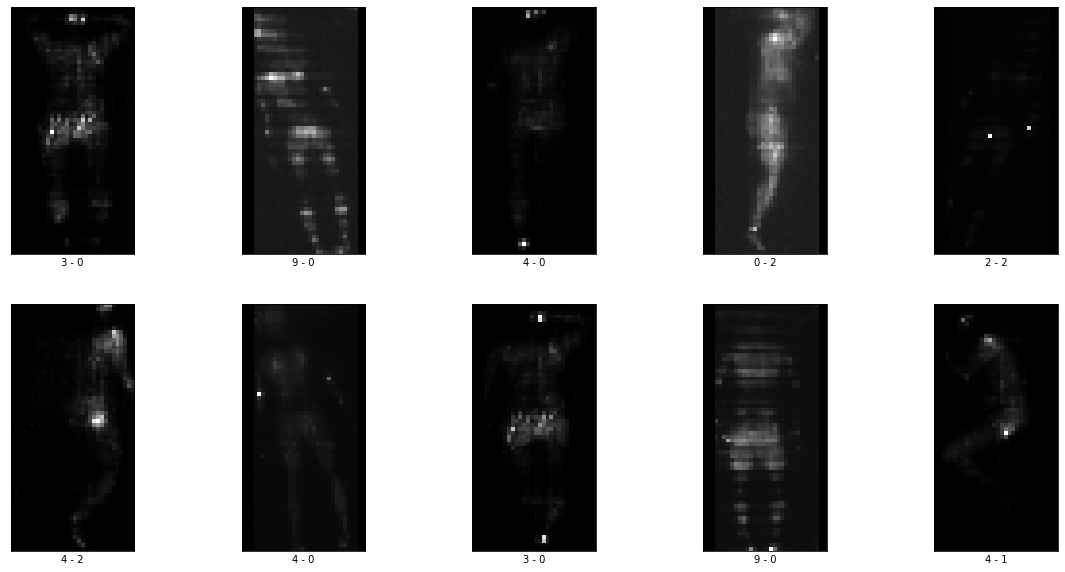

In [12]:
predictions_subject = model_subject.predict(test_data)
predictions_position = model_position.predict(test_data)

predictions_subject = predictions_subject.argmax(axis=-1)
predictions_position = predictions_position.argmax(axis=-1)

plt.figure(figsize=(20,10))

for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    label = str(predictions_subject[i-1]) + ' - ' + str(predictions_position[i-1])
    plt.imshow(test_data[i-1].reshape(64, 32), cmap='gray')
    plt.xlabel(label)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[Text(0, 0.5, 'supine'), Text(0, 1.5, 'right'), Text(0, 2.5, 'left')]

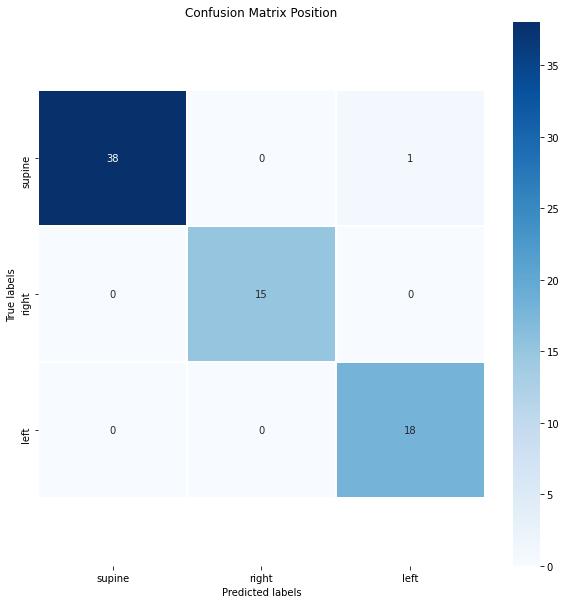

In [13]:
labels = ['Supine', 'Right', 'Left']
cm = confusion_matrix(test_labels_p, predictions_position, [0,1,2])

f,ax= plt.subplots(figsize=(10,10))
sas.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap = "Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Position')
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

plt.show()


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


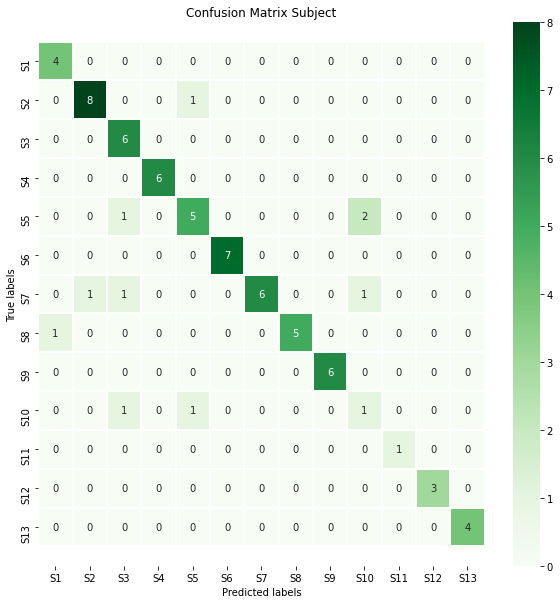

In [14]:
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6','S7', 'S8', 'S9','S10', 'S11', 'S12','S13']

cm = confusion_matrix(test_labels_s, predictions_subject, [0,1,2,3,4,5,6,7,8,9,10,11,12])

f,ax= plt.subplots(figsize=(10,10))
sas.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap="Greens")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Subject')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()


**EXPERIMENT 2**

In [15]:
#load the model
model_position = load_model('Model/model_position_2.h5')
model_subject = load_model('Model/model_subject_2.h5')

#summarize model
model_position.summary()
model_subject.summary()

with open('Model/test_2.pkl', 'rb') as f:
    [test_data_s, test_data_p, test_subject, test_position, test_labels_s, test_labels_p] = pickle.load(f)
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1

In [16]:
print('EVALUATION POSITIONS')
model_position.evaluate(test_data_p, test_position)

print()
print('EVALUATION SUBJECTS')
model_subject.evaluate(test_data_s, test_subject)

print()

EVALUATION POSITIONS
3/3 [==============================] - 0s 1ms/step - loss: 0.1592 - accuracy: 0.9444

EVALUATION SUBJECTS
3/3 [==============================] - 0s 2ms/step - loss: 1.4715 - accuracy: 0.7222



In [17]:
predictions_position = model_position.predict(test_data_p)
predictions_position = predictions_position.argmax(axis=-1)

predictions_subject = model_subject.predict(test_data_s)
predictions_subject = predictions_subject.argmax(axis=-1)


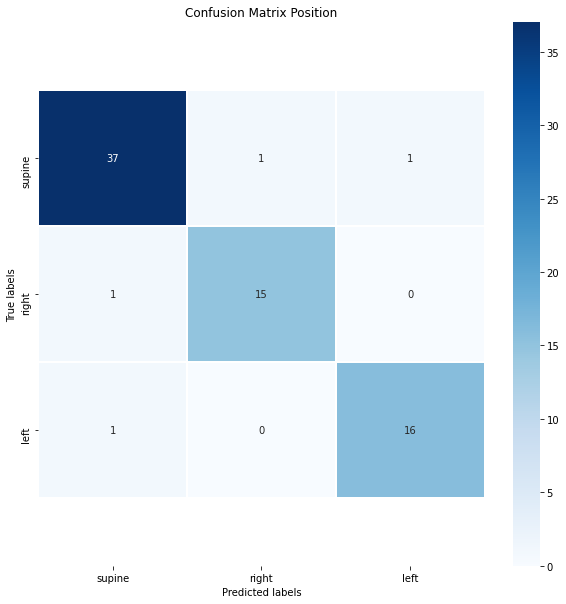

In [18]:
labels = ['Supine', 'Right', 'Left']

cm = confusion_matrix(test_labels_p, predictions_position, [0,1,2])

f,ax= plt.subplots(figsize=(10,10))
sas.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap = "Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Position')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()


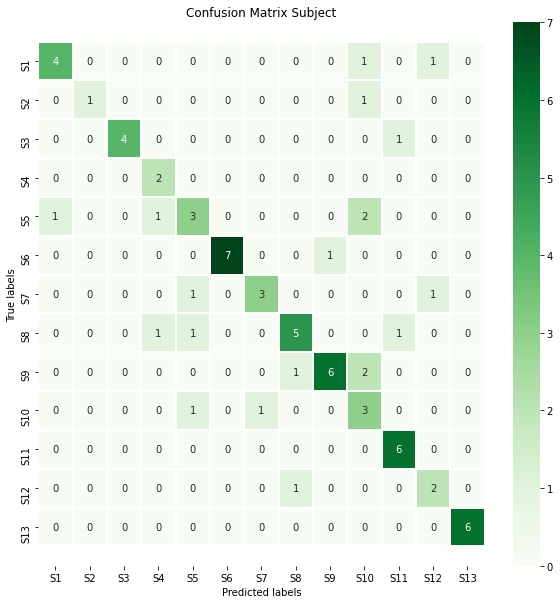

In [19]:
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6','S7', 'S8', 'S9','S10', 'S11', 'S12','S13']

cm = confusion_matrix(test_labels_s, predictions_subject, [0,1,2,3,4,5,6,7,8,9,10,11,12])

f,ax= plt.subplots(figsize=(10,10))
sas.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap="Greens") 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Subject') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()
